In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

In [37]:
#read text file in index
df = pd.read_csv('C:\\Users\\Faisa_k2n8tj8\\OneDrive\\Desktop\\household.txt', sep=';',
                  parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'],index_col='dt')

In [38]:
# Check the size of our data (Number of rows and columns)

df.shape

(2075259, 7)

In [39]:
# Check sample records of our data

df.sample()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2008-01-22 09:58:00,0.478,0.188,241.13,2.2,0.0,2.0,0.0


In [40]:
# check missing values

df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [41]:
# fill missing values using forward-fill and make the changes permanent in the original dataframe

df.ffill(axis=0,inplace=True)

In [42]:
# Feature Engineering - Creation of new Feature 'Power Consumption'

eq1 = (df['Global_active_power']*1000/60) 
eq2 = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['power_consumption'] = eq1 - eq2
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power_consumption
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [43]:
# Creation of Date Time column for aggregation operation
df['Date'] = df.index.date
df['time'] = df.index.time

df['Date'] = df['Date'].astype(str)
df['time'] = df['time'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   power_consumption      float64
 8   Date                   object 
 9   time                   object 
dtypes: float64(8), object(2)
memory usage: 174.2+ MB


In [44]:
# Convert into DateTime and dropping from Original df

df['exact_time'] = df['Date']+";"+df['time']
df['exact_time_DT'] = pd.to_datetime(df['exact_time'],format="%Y-%m-%d;%H:%M:%S")
data = df.drop(['Date', 'time','exact_time'],axis = 1).sort_values(by=['exact_time_DT'])
data.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power_consumption,exact_time_DT
dt,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667,2006-12-16 17:24:00
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333,2006-12-16 17:25:00
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667,2006-12-16 17:26:00
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000,2006-12-16 17:27:00
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000,2006-12-16 17:28:00
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0,39.666667,2006-12-16 17:29:00
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0,43.700000,2006-12-16 17:30:00
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0,43.666667,2006-12-16 17:31:00
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0,43.133333,2006-12-16 17:32:00


In [45]:
# filter out 2006 data, only keep data post 2006
df_subset = data[data.index.year>2006]
df_subset.shape

(2053263, 9)

In [46]:
# Grouped on Date column by Week 

df_subset = df_subset.groupby(pd.Grouper(key='exact_time_DT',freq='M')).sum()

df_subset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power_consumption
exact_time_DT,,,,,,,,
2007-01-31,69017.230,5922.962,10753991.67,292264.0,56433.0,79274.0,329611.0,684969.166667
2007-02-28,56494.978,4581.728,9697733.22,238489.2,47584.0,64604.0,270308.0,559086.966667
2007-03-31,58862.574,5122.312,10736523.72,248773.8,60769.0,104762.0,290361.0,525150.900000
2007-04-30,37013.182,5463.378,10330316.35,159216.8,42078.0,38417.0,189503.0,346888.366667
2007-05-31,44008.872,5148.894,10498362.16,191838.8,75737.0,72132.0,229448.0,356164.200000


In [47]:
# subset of only power consumption column

df_power_consumption = df_subset[['power_consumption']]

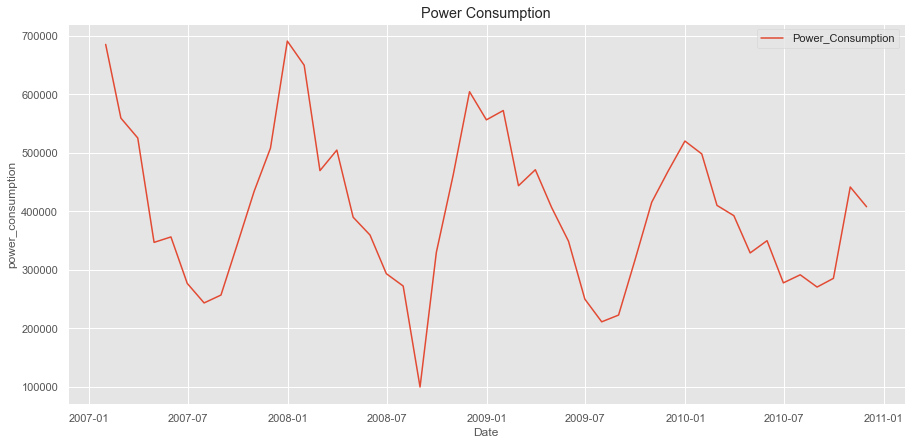

In [48]:
# plot normal graph for power consumption, date which us year and month in x and y is power consumption been use

plt.figure(figsize=(15,7))
plt.title("Power Consumption")
plt.xlabel('Date')
plt.ylabel('power_consumption')
plt.plot(df_power_consumption['power_consumption'],label='Power_Consumption')
plt.legend(loc="best")
plt.show()

In [49]:
#Augmented Dickey–Fuller test:

print('Results of Dickey Fuller Test:')
print('*'*50)
dftest = adfuller(df_power_consumption['power_consumption'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
**************************************************
Test Statistic                 -0.982274
p-value                         0.759674
#Lags Used                      9.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [50]:
#Standard ARIMA Model, which is predict future values based on past values

ARIMA_model = pm.auto_arima(df_power_consumption['power_consumption'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

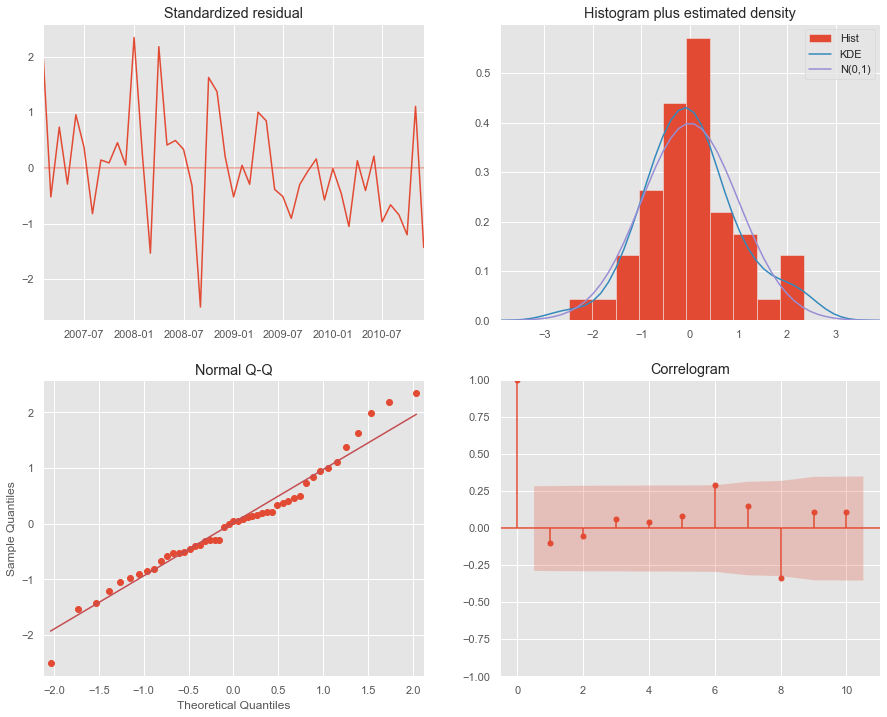

In [51]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()